<a href="https://colab.research.google.com/github/KevinSpadesAce/Colab-notebooks/blob/main/Probabilistic_Classification_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Probabilistic Classification with Structured Data  
## Predicting cancer malignancy with calibrated probabilities (and decision-making)

**What you’ll build:** a classifier that outputs **probabilities** (not just labels), plus a simple decision layer that uses those probabilities responsibly.

**Dataset:** the *Wisconsin Breast Cancer* dataset (structured numeric features from cell nuclei measurements). This is a classic, real biomedical dataset used for binary classification.

**Why probabilities matter in the real world**
In many settings (medical triage, fraud, risk scoring, quality control) you don’t just want “positive/negative”. You want:
- *How confident* is the model?
- What threshold should we use given the *cost* of mistakes?
- Are predicted probabilities *trustworthy* (calibrated)?

We’ll cover:
- probability outputs (`predict_proba`)
- evaluation metrics (including probability-aware ones)
- calibration (reliability diagrams + Brier score + log loss)
- choosing thresholds based on costs and workflows (auto-decide vs human review)



---

## 1) What is probabilistic classification?

A classifier maps an input vector \(x\) (structured features) to a class label \(y in {0,1}).  



That single number is incredibly useful:
- you can change the decision threshold later without retraining,
- you can rank cases by risk,
- you can send “uncertain” cases to a human.

### Calibration in one sentence
A model is **well calibrated** if among cases it predicts with probability 0.8, about **80%** are truly positive.

---

### ✅ Mini-exercise (concept check)
1. If a model predicts a case has a 0.98 probability of being malignant, should the system always auto-diagnose?  
2. Give one reason you might still require a clinician to review it.



---

## 2) Set-up

Run the next cell to import libraries.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    log_loss, brier_score_loss,
    roc_curve, precision_recall_curve
)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



---

## 3) Load a structured dataset

We’ll use `load_breast_cancer()` from scikit-learn.
- Features: numeric measurements (e.g., radius, texture, perimeter, etc.)
- Target: malignant vs benign

**Important note about labels**
In this dataset, scikit-learn encodes:
- `target = 0` → malignant
- `target = 1` → benign

To make the probability interpretation more intuitive, we’ll create:
- `y = 1` meaning **malignant**
- `y = 0` meaning **benign**


In [ ]:

data = load_breast_cancer(as_frame=True)
X = data.data
y_original = data.target  # 0 malignant, 1 benign
y = (y_original == 0).astype(int)  # 1 malignant, 0 benign

df = X.copy()
df["malignant"] = y
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


Let’s inspect class balance (is the dataset imbalanced?).

In [ ]:

df["malignant"].value_counts().rename(index={0: "benign(0)", 1: "malignant(1)"})


,count
malignant,
benign(0),357
malignant(1),212



---

## 4) Train/test split

We keep a held-out test set for honest evaluation.


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((455, 30), (114, 30))


---

## 5) Two probabilistic models to compare

### Model A: Logistic Regression (with scaling)
- Works well for many structured problems.
- Outputs probabilities naturally.
- Needs feature scaling for best performance (hence `StandardScaler`).

### Model B: Random Forest
- Strong non-linear model.
- Often has excellent ranking performance.
- Probabilities can be **poorly calibrated** (common for tree ensembles), so calibration is especially interesting here.


In [ ]:

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight=None
)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

lr_proba = lr.predict_proba(X_test)[:, 1]   # P(malignant)
rf_proba = rf.predict_proba(X_test)[:, 1]   # P(malignant)

lr_proba[:5], rf_proba[:5]


(array([3.64568116e-04, 9.99999989e-01, 4.25679471e-02, 5.76187322e-01,
        5.09155489e-01]),
 array([0.01  , 1.    , 0.305 , 0.5475, 0.075 ]))


---

## 6) Metrics: what they mean, when to use them, and common traps

A lot of confusion comes from mixing up **threshold-based** metrics with **probability-based** metrics.

### 6.1 Threshold-based metrics (need a decision threshold)
You pick a threshold (often 0.5) and convert probabilities to labels:
- predict malignant if \(p \ge t\)

Then you can compute:

**Confusion matrix**
- **TP**: malignant correctly detected  
- **FP**: benign incorrectly flagged as malignant  
- **FN**: malignant missed  
- **TN**: benign correctly identified  

From these:

**Accuracy**
- can be misleading with imbalance

**Precision** (positive predictive value)

- “When we say malignant, how often are we right?”

**Recall** (sensitivity / true positive rate)

- “How many malignant cases do we catch?”
- in medical screening, recall is often critical

**F1 score**
- balances precision and recall

**Balanced accuracy**
- average of recall for each class
- helpful when classes are imbalanced

### 6.2 Ranking metrics (do NOT require choosing one threshold)
These look at how well the model ranks malignant cases above benign cases:

**ROC AUC**
- probability that a random malignant case has a higher score than a random benign case
- can look optimistic when the positive class is rare

**Average Precision (PR AUC)**
- area under Precision–Recall curve
- typically more informative when positives are rare and you care about catching them

### 6.3 Probability-quality metrics (measure how good the probabilities are)
These are crucial when you’ll use the probabilities for decisions:

**Log loss (cross-entropy)**


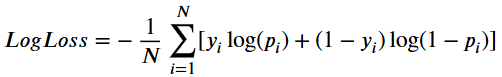
- heavily punishes confident wrong predictions
- lower is better

**Brier score**


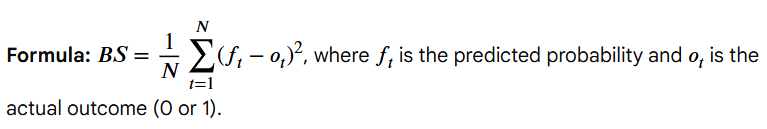
- mean squared error of probabilities
- lower is better
- strongly connected to calibration
- A score of 0 represents perfect accuracy, while a score of 1 represents perfect inaccuracy.

---

### ✅ Mini-exercise (metrics reasoning)
1. If a hospital wants to miss as few malignant cases as possible, which metric would you prioritise: precision or recall? Why?  
2. Which metric punishes a model most for being *very confident and wrong*: log loss or accuracy?



---

## 7) Compute metrics for both models (with a default threshold)

We’ll start with threshold \(t=0.5\) just as a baseline.  
Later we’ll choose thresholds based on costs.

We’ll compute:
- accuracy, balanced accuracy, precision, recall, F1
- ROC AUC, PR AUC
- log loss, Brier score


In [ ]:

def evaluate_all(y_true, proba, name, threshold=0.5):
    y_pred = (proba >= threshold).astype(int)

    out = {
        "model": name,
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, proba),
        "avg_precision": average_precision_score(y_true, proba),
        "log_loss": log_loss(y_true, proba),
        "brier": brier_score_loss(y_true, proba),
    }
    return out

results = pd.DataFrame([
    evaluate_all(y_test, lr_proba, "LogReg (raw)"),
    evaluate_all(y_test, rf_proba, "RandomForest (raw)"),
])

results


,model,threshold,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,avg_precision,log_loss,brier
0,LogReg (raw),0.5,0.964912,0.957341,0.975,0.928571,0.95122,0.996032,0.994274,0.077265,0.021313
1,RandomForest (raw),0.5,0.964912,0.957341,0.975,0.928571,0.95122,0.994213,0.991057,0.113256,0.031555



### Confusion matrices at threshold 0.5


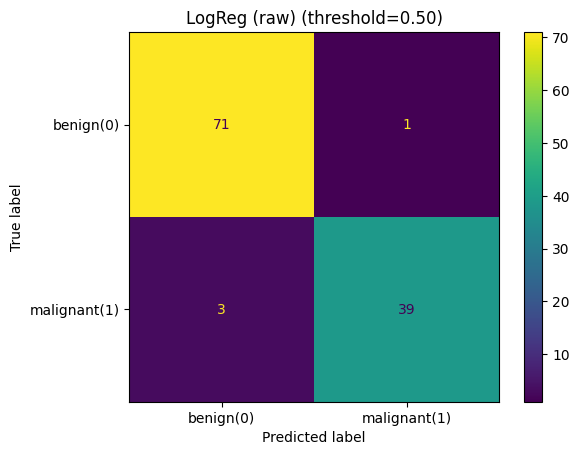

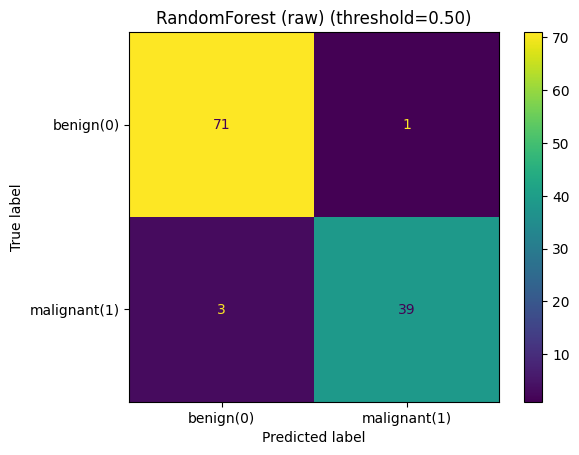

In [ ]:

def show_confusion(y_true, proba, threshold, title):
    y_pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["benign(0)", "malignant(1)"]).plot(values_format="d")
    plt.title(f"{title} (threshold={threshold:.2f})")
    plt.show()

show_confusion(y_test, lr_proba, 0.5, "LogReg (raw)")
show_confusion(y_test, rf_proba, 0.5, "RandomForest (raw)")



---

## 8) Visualise ranking: ROC and Precision–Recall curves

These curves show model behaviour across *all* thresholds.

### ROC curve
- x-axis: false positive rate
- y-axis: true positive rate (recall)

### Precision–Recall curve
- x-axis: recall
- y-axis: precision

PR curves are often more informative when the positive class is rarer and you care about precision/recall trade-offs.


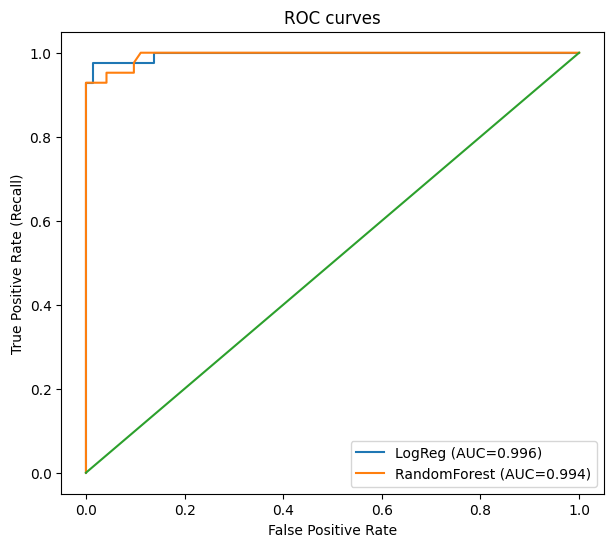

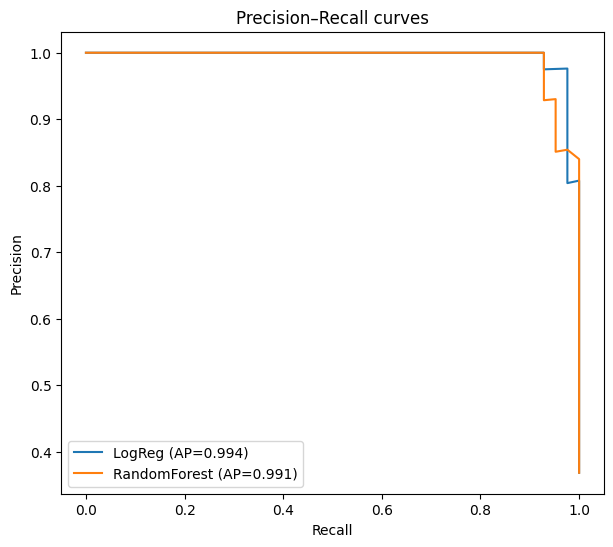

In [ ]:

def plot_roc_curves(y_true, probas, names):
    plt.figure(figsize=(7, 6))
    for proba, name in zip(probas, names):
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_true, proba):.3f})")
    plt.plot([0, 1], [0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC curves")
    plt.legend()
    plt.show()

def plot_pr_curves(y_true, probas, names):
    plt.figure(figsize=(7, 6))
    for proba, name in zip(probas, names):
        precision, recall, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall curves")
    plt.legend()
    plt.show()

plot_roc_curves(y_test, [lr_proba, rf_proba], ["LogReg", "RandomForest"])
plot_pr_curves(y_test, [lr_proba, rf_proba], ["LogReg", "RandomForest"])



---

## 9) Calibration: do the probabilities mean what they claim?

A model can have great ROC AUC (great ranking) but poor calibration (probabilities not trustworthy).

We’ll inspect calibration using a **reliability diagram**:
- Bin predictions into ranges (e.g., 0.0–0.1, …)
- Compare mean predicted probability vs actual fraction malignant in that bin

Perfect calibration lies on the diagonal.


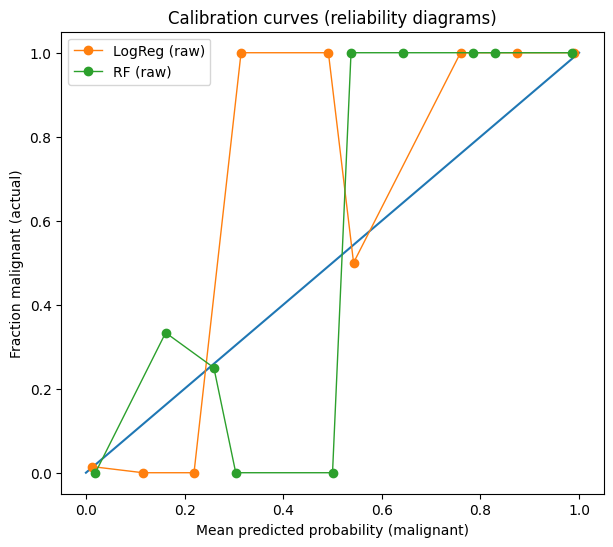

In [ ]:

def plot_calibration_curves(y_true, probas, names, n_bins=10):
    plt.figure(figsize=(7, 6))
    plt.plot([0, 1], [0, 1])  # perfect calibration

    for proba, name in zip(probas, names):
        frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=n_bins, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=name)

    plt.xlabel("Mean predicted probability (malignant)")
    plt.ylabel("Fraction malignant (actual)")
    plt.title("Calibration curves (reliability diagrams)")
    plt.legend()
    plt.show()

plot_calibration_curves(y_test, [lr_proba, rf_proba], ["LogReg (raw)", "RF (raw)"])



### Probability-quality metrics again (why Brier and log loss matter here)
- **Brier score** measures squared error of probabilities: if a model says 0.9 and it’s actually 0, that’s very bad.
- **Log loss** punishes confident wrong predictions even more aggressively.

These metrics often change after calibration even when ROC AUC stays similar.



---

## 10) Calibrate probabilities (sigmoid vs isotonic)

We’ll calibrate the Random Forest (which often benefits the most).

Two calibration methods:
- **sigmoid (Platt scaling):** fits an S-shaped curve; robust default
- **isotonic:** flexible step-like function; can overfit with limited data

Important: calibration must be trained on training data only (we do this via CV inside `CalibratedClassifierCV`).


In [ ]:

rf_sigmoid = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
rf_isotonic = CalibratedClassifierCV(rf, method="isotonic", cv=5)

rf_sigmoid.fit(X_train, y_train)
rf_isotonic.fit(X_train, y_train)

rf_sig_proba = rf_sigmoid.predict_proba(X_test)[:, 1]
rf_iso_proba = rf_isotonic.predict_proba(X_test)[:, 1]

pd.DataFrame([
    evaluate_all(y_test, rf_proba, "RF (raw)"),
    evaluate_all(y_test, rf_sig_proba, "RF + sigmoid"),
    evaluate_all(y_test, rf_iso_proba, "RF + isotonic"),
])


,model,threshold,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,avg_precision,log_loss,brier
0,RF (raw),0.5,0.964912,0.957341,0.975,0.928571,0.951220,0.994213,0.991057,0.113256,0.031555
1,RF + sigmoid,0.5,0.973684,0.964286,1.000,0.928571,0.962963,0.994378,0.991465,0.118763,0.029769
2,RF + isotonic,0.5,0.964912,0.957341,0.975,0.928571,0.951220,0.990410,0.982497,0.112087,0.030499


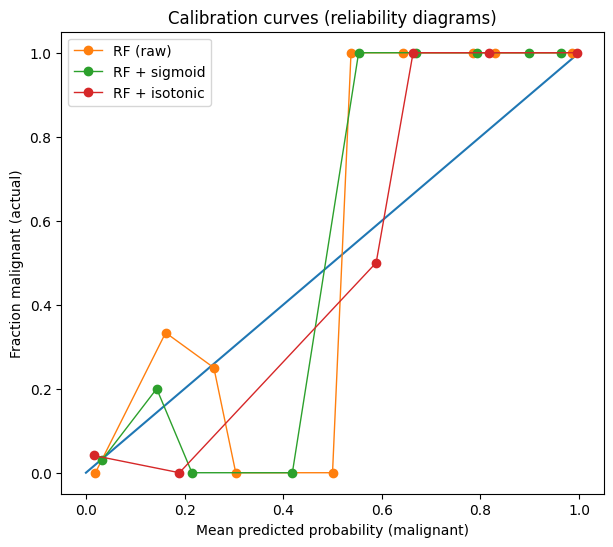

In [ ]:

plot_calibration_curves(
    y_test,
    [rf_proba, rf_sig_proba, rf_iso_proba],
    ["RF (raw)", "RF + sigmoid", "RF + isotonic"]
)



---

### ✅ Mini-exercise (calibration)
1. Which calibration method improved **Brier score** the most for the Random Forest in your run?  
2. If isotonic looks “wiggly”, what does that suggest about data size vs flexibility?



---

## 11) Choosing a threshold based on costs (a practical workflow)

In screening/triage, the cost of mistakes is not symmetric.

Example:
- False negative (missing malignancy) is very costly → cost = 25
- False positive (flagging benign as malignant) is costly too → cost = 5

We’ll pick the threshold that minimises expected cost on the test set, using calibrated RF probabilities (sigmoid).


In [ ]:

def expected_cost(y_true, proba, threshold, cost_fp=5.0, cost_fn=25.0):
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fp * fp + cost_fn * fn

def sweep_thresholds(y_true, proba, cost_fp=5.0, cost_fn=25.0, n=401):
    thresholds = np.linspace(0, 1, n)
    costs = np.array([expected_cost(y_true, proba, t, cost_fp, cost_fn) for t in thresholds])
    best_idx = costs.argmin()
    return thresholds, costs, thresholds[best_idx], costs[best_idx]

COST_FP = 5.0
COST_FN = 25.0

thresholds, costs, best_t, best_cost = sweep_thresholds(
    y_test, rf_sig_proba, cost_fp=COST_FP, cost_fn=COST_FN
)

best_t, best_cost


(np.float64(0.0675), np.float64(35.0))

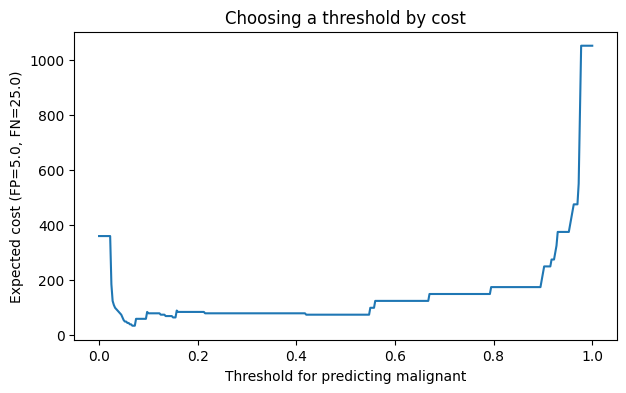

Best threshold: 0.0675


In [ ]:

plt.figure(figsize=(7, 4))
plt.plot(thresholds, costs)
plt.xlabel("Threshold for predicting malignant")
plt.ylabel(f"Expected cost (FP={COST_FP}, FN={COST_FN})")
plt.title("Choosing a threshold by cost")
plt.show()

print("Best threshold:", best_t)


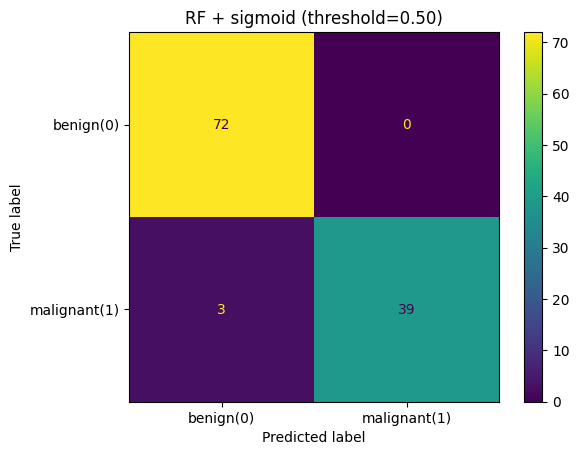

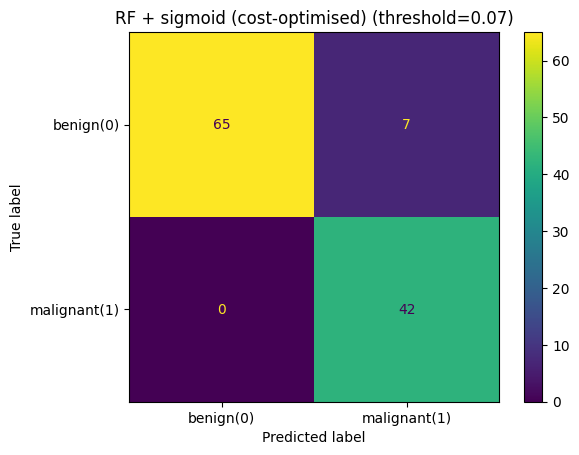

In [ ]:

show_confusion(y_test, rf_sig_proba, 0.50, "RF + sigmoid")
show_confusion(y_test, rf_sig_proba, best_t, "RF + sigmoid (cost-optimised)")



---

### ✅ Mini-exercise (threshold intuition)
If the cost of false negatives increases, would you expect the best threshold to move **up** or **down**? Explain in one sentence.



---

## 12) A simple triage policy: auto-decide vs human review

Many real systems use 3 actions:
- **auto-benign** if probability is very low
- **auto-malignant** if probability is very high
- **review** otherwise

Example policy:
- if \(p < 0.05\) → auto-benign  
- if \(p > 0.90\) → auto-malignant  
- else → review

Let’s see:
- what fraction goes to review
- how accurate the auto-decisions are


In [ ]:

def triage_policy(proba, low=0.05, high=0.90):
    action = np.full_like(proba, "review", dtype=object)
    action[proba <= low] = "auto_benign"
    action[proba >= high] = "auto_malignant"
    return action

actions = triage_policy(rf_sig_proba, low=0.05, high=0.90)
pd.Series(actions).value_counts(normalize=True).rename("share")


,share
auto_benign,0.535088
auto_malignant,0.289474
review,0.175439


In [ ]:

review_mask = actions == "review"
auto_mask = ~review_mask

auto_y_true = y_test[auto_mask]
auto_proba = rf_sig_proba[auto_mask]

# Convert auto decisions into labels:
# - auto_benign -> 0
# - auto_malignant -> 1
auto_y_pred = (auto_proba >= 0.5).astype(int)

cm = confusion_matrix(auto_y_true, auto_y_pred)
acc = accuracy_score(auto_y_true, auto_y_pred)

acc, cm


(1.0,
 array([[61,  0],
        [ 0, 33]]))


---

## 13) Common pitfalls (short checklist)

- **Using accuracy alone:** you’ll miss important trade-offs.  
- **Ignoring calibration:** probabilities may be misleading even if AUC is strong.  
- **Picking 0.5 by habit:** thresholds should reflect costs and workflow capacity.  
- **Data leakage:** do not tune/calibrate using the test set.

---

# Final exercise (capstone)

You’re building a triage tool for clinicians.

**Scenario**
- Missing a malignant case (FN) cost: **50**
- Incorrectly flagging benign as malignant (FP) cost: **10**
- Sending a case to human review cost: **2** (time + attention)

**Task**
1. Use calibrated probabilities from `rf_sig_proba` (Random Forest + sigmoid calibration).
2. Build a triage rule with two thresholds: `low` and `high`:
   - \(p \le low\) → auto-benign  
   - \(p \ge high\) → auto-malignant  
   - else → review  
3. Define total cost:
   - review cases cost 2 each,
   - FP cost 10 each (auto-decisions only),
   - FN cost 50 each (auto-decisions only).
4. Grid search over `low` and `high` (ensure `low < high`) to minimise total cost.
5. Report:
   - best `(low, high)`,
   - share reviewed,
   - confusion matrix for auto-decisions,
   - total cost.

**Stretch (optional)**
Repeat using `lr_proba` (LogReg raw) and compare the best total cost.  
Does better calibration or better ranking matter more in this scenario?



---

## Appendix: helper functions for the exercise

Edit and run the next cell to complete the grid search.


In [ ]:

# ====== EXERCISE HELPER (edit this cell) ======

COST_FN = 50
COST_FP = 10
COST_REVIEW = 2

def triage_cost(y_true, proba, low, high, cost_fp=COST_FP, cost_fn=COST_FN, cost_review=COST_REVIEW):
    '''
    Total cost under triage:
      p <= low  -> auto_benign (predict 0)
      p >= high -> auto_malignant (predict 1)
      else      -> review
    '''
    action = np.full_like(proba, "review", dtype=object)
    action[proba <= low] = "auto_benign"
    action[proba >= high] = "auto_malignant"

    review_mask = action == "review"
    total = cost_review * review_mask.sum()

    auto_mask = ~review_mask
    y_auto = y_true[auto_mask]
    p_auto = proba[auto_mask]

    # Implied labels for auto decisions: benign if p is low, malignant if p is high
    # Using p>=0.5 works because only low/high regions remain, but you can also derive from 'action'.
    y_pred_auto = (p_auto >= 0.5).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_auto, y_pred_auto).ravel()
    total += cost_fp * fp + cost_fn * fn

    return total, (tn, fp, fn, tp), review_mask.mean()

# TODO: grid search
# Example:
# lows = np.linspace(0.0, 0.5, 51)
# highs = np.linspace(0.5, 1.0, 51)
#
# best = (np.inf, None, None, None, None)  # cost, low, high, cm, review_share
# for low in lows:
#     for high in highs:
#         if low >= high:
#             continue
#         cost, cm_parts, review_share = triage_cost(y_test.values, rf_sig_proba, low, high)
#         if cost < best[0]:
#             best = (cost, low, high, cm_parts, review_share)
# best
